# House Prices - Advanced Regression Techniques
### Predict sales prices and practice feature engineering

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [89]:
df = pd.read_csv('houses.csv')
df.shape

(1460, 81)

In [90]:
# Create a series with the percentage of NaN values in columns
nan_percent = df.isnull().mean()*100
# Create a list of column names with 30+ percent NaNs (feels justified to drop them, though it's open to debate)
cols_30plus_nans = nan_percent[nan_percent > 30].index.tolist()
print(cols_30plus_nans)

['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [91]:
# Drop high NaN columns
df2 = df.drop(cols_30plus_nans, axis=1)
# Drop the 'Id' column as uninformative
df2.drop('Id', axis=1, inplace=True)
# Drop duplicates in case there are any
df2.drop_duplicates(inplace=True)
df2.shape

(1460, 74)

In [92]:
# Check the remaining columns with NaNs
nan_percent[(nan_percent <= 30) & (nan_percent > 0)]

LotFrontage     17.739726
MasVnrArea       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtFinType2     2.602740
Electrical       0.068493
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
dtype: float64

In [93]:
# Create a list of remaining columns with NaNs
cols_30minus_nans = nan_percent[(nan_percent <= 30) & (nan_percent > 0)].index.tolist()

- It seems reasonable to do a small research whether these columns can be potential predictors for SalePrice.
- If not, we can just dispose of them to avoid the hassle of dealing with NaN values. 
- But first let's one-hot-encode the 'object' features to test if they correlate with the target.

In [94]:
cols_nan_plus_target = cols_30minus_nans + ['SalePrice']
df2_nan = df2[cols_nan_plus_target]      # Create a dataframe with only NaN-containing columns plus the target for further correlating them

In [95]:
df2_nan.select_dtypes(exclude='number').nunique()     # check the number of unique values in 'object' columns

BsmtQual        4
BsmtCond        4
BsmtExposure    4
BsmtFinType1    6
BsmtFinType2    6
Electrical      5
GarageType      6
GarageFinish    3
GarageQual      5
GarageCond      5
dtype: int64

In [96]:
# One-hot-encode categorical features
cat_cols = df2_nan.select_dtypes(exclude='number').columns.tolist()
df2_nan_dummies = pd.get_dummies(df2_nan, columns = cat_cols)
df2_nan_dummies.columns

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'SalePrice', 'BsmtQual_Ex',
       'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtCond_Fa',
       'BsmtCond_Gd', 'BsmtCond_Po', 'BsmtCond_TA', 'BsmtExposure_Av',
       'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No',
       'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ',
       'BsmtFinType1_LwQ', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf',
       'BsmtFinType2_ALQ', 'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ',
       'BsmtFinType2_LwQ', 'BsmtFinType2_Rec', 'BsmtFinType2_Unf',
       'Electrical_FuseA', 'Electrical_FuseF', 'Electrical_FuseP',
       'Electrical_Mix', 'Electrical_SBrkr', 'GarageType_2Types',
       'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn',
       'GarageType_CarPort', 'GarageType_Detchd', 'GarageFinish_Fin',
       'GarageFinish_RFn', 'GarageFinish_Unf', 'GarageQual_Ex',
       'GarageQual_Fa', 'GarageQual_Gd', 'GarageQual_Po', 'GarageQual_TA',
       'GarageCond_Ex', 'GarageCond_F

In [97]:
# Filter out strong enough (|r| > 0.45) correlations between features and target
corrs = df2_nan_dummies.corr()['SalePrice'].drop('SalePrice')
high_corr = corrs[abs(corrs) > 0.45]
print(high_corr)

MasVnrArea     0.477493
GarageYrBlt    0.486362
BsmtQual_Ex    0.553105
BsmtQual_TA   -0.452394
Name: SalePrice, dtype: float64


- Two boolean subfeatures of the parent categorical feature 'BsmtQual' (basement quality) showed relatively high correlations with 'SalePrice'. Let's keep it for further analysis. The missing values are few and they won't be a problem after one-hot-encoding.
- Let's now explore numerical features "MasVnrArea" (8 NaNs) and GarageYrBlt (81 NaNs) to decide on imputing vs dropping NaN values.

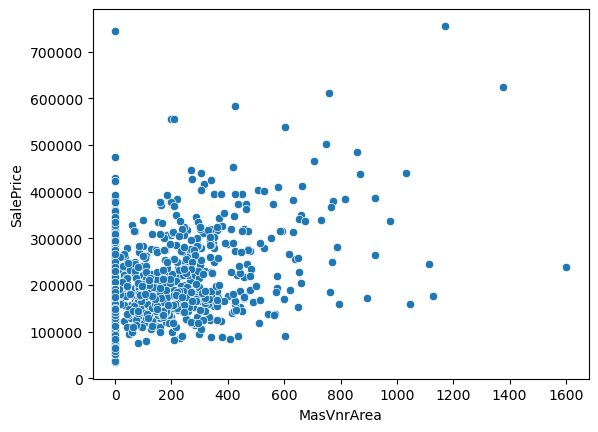

In [98]:
sns.scatterplot(df, x = 'MasVnrArea', y = 'SalePrice') # MasVnrArea stands for masonry veneer area in square feet
plt.show()

In [99]:
# Calculating the number of zero (not NaN!) values present in the feature
df2.MasVnrArea[df.MasVnrArea == 0].shape[0]

861

- The 'MasVnrArea' feature is strongly zero-inflated. But it's well understandable as not every house has the 'veneer' thing.
- The missing values is reasonable to interpret as absence of veneer, so we will impute zeros.
- We will later address the distribution of this feature with an appropriate transformation.

In [100]:
df2.MasVnrArea = df2.MasVnrArea.fillna(0) # impute zeros
df2.MasVnrArea.isnull().sum()

0

- Another potentially interesting feature, 'GarageYrBlt' (year garage was built), has 81 missing values.
- However the dataset has a closely related feature ('YearBuit' - original construction year) without omitted values.
- Let's check whether these two features are correlated. If this is the case, it is justified to exclude 'GarageYrBlt' from further analysis as an obviously less significant house property. Besides, in doing so we get rid of a potential multicollinearity problem.

In [101]:
df2.GarageYrBlt.corr(df2["YearBuilt"]).round(3)

0.826

- The correlation coefficient is really strong. Hence we are going to drop 'GarageYrBlt' feature.

## Assemblying the final cleaned dataframe

In [102]:
print(cols_30minus_nans)        # recollecting the names of remaining features (wit NaNs) weakly correlated to the target

['LotFrontage', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']


- 'MasVnrArea' and 'BsmtQual' will be kept, the other NaN-containing features will be dropped

In [103]:
cols_to_keep = ['MasVnrArea', 'BsmtQual']
cols_to_drop = [x for x in cols_30minus_nans if x not in cols_to_keep]
df3 = df2.drop(cols_to_drop, axis=1)

# Check if any NaNs left
has_nans = False
for column, nan_count in df3.isnull().sum().items():
    if nan_count > 0:
        print(f"Column {column} still has {nan_count} NaN(s)")
        has_nans = True
if not has_nans:
    print("No NaNs detected!")

Column BsmtQual still has 37 NaN(s)


- 'BdmtQual' will be one-hot-encoded, so the NaN values won't be a problem

### Now let's filter out numeric features which are either not or only weakly (|r|<0.45) correlated with the target

In [104]:
corr_matrix = df3.select_dtypes(include='number').corr().round(2)               # calculating all correlations
low_corrs = corr_matrix['SalePrice'][abs(corr_matrix['SalePrice']) <= 0.45]     # extracting low correlations (r<=0.45)
print(low_corrs)

MSSubClass      -0.08
LotArea          0.26
OverallCond     -0.08
BsmtFinSF1       0.39
BsmtFinSF2      -0.01
BsmtUnfSF        0.21
2ndFlrSF         0.32
LowQualFinSF    -0.03
BsmtFullBath     0.23
BsmtHalfBath    -0.02
HalfBath         0.28
BedroomAbvGr     0.17
KitchenAbvGr    -0.14
WoodDeckSF       0.32
OpenPorchSF      0.32
EnclosedPorch   -0.13
3SsnPorch        0.04
ScreenPorch      0.11
PoolArea         0.09
MiscVal         -0.02
MoSold           0.05
YrSold          -0.03
Name: SalePrice, dtype: float64


In [105]:
cols_to_drop = list(low_corrs.index)
df3 = df3.drop(cols_to_drop, axis=1)    # drop the low correlated numeric features
df3.shape

(1460, 41)

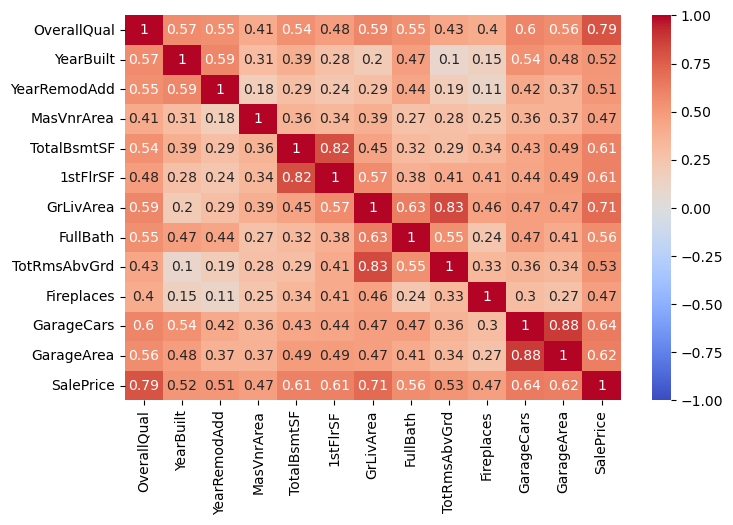

In [106]:
# Explore the remaining correlations among numerical features

corr_matrix2 = df3.select_dtypes(include='number').corr().round(2)

plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix2, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

### Let's filter out redundant features (strongly mutually correlated: |r| > 0.8) to try to avoid multicollinearity problems

- 'TotalBsmtSF' (total basement area square feet) and '1stFlrSF' (first floor square feet) features are strongly correlated and have comparable correlation strengths to the target.

<Axes: xlabel='1stFlrSF', ylabel='Count'>

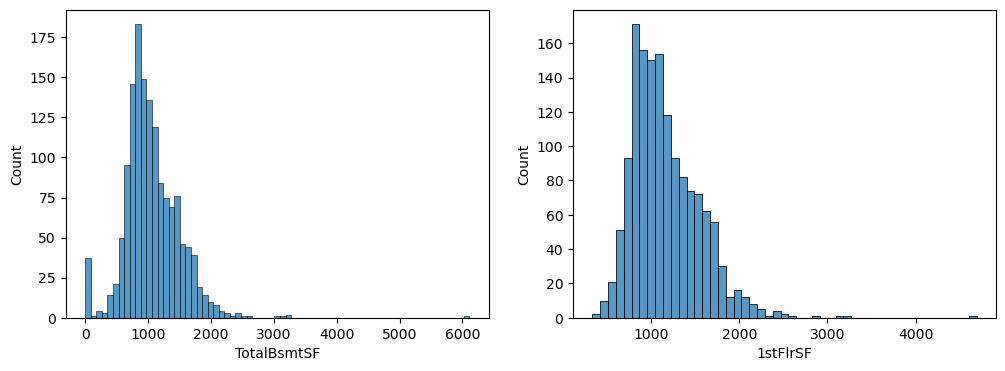

In [107]:
# Visualize distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data = df3, x = 'TotalBsmtSF', ax = ax1)
sns.histplot(data = df3, x = '1stFlrSF', ax = ax2)

- Given a slightly better looking distribution of '1stFlrSF' feature and its subjectively higher importance for a potential buyer, let's keep it and drop the other one.

In [108]:
df3 = df3.drop('TotalBsmtSF', axis=1)

- The second pair of strongly correlated features are 'GrLivArea' (Above ground living area square feet) and 'TotRmsAbvGrd' (total rooms above ground)

<Axes: xlabel='TotRmsAbvGrd', ylabel='Count'>

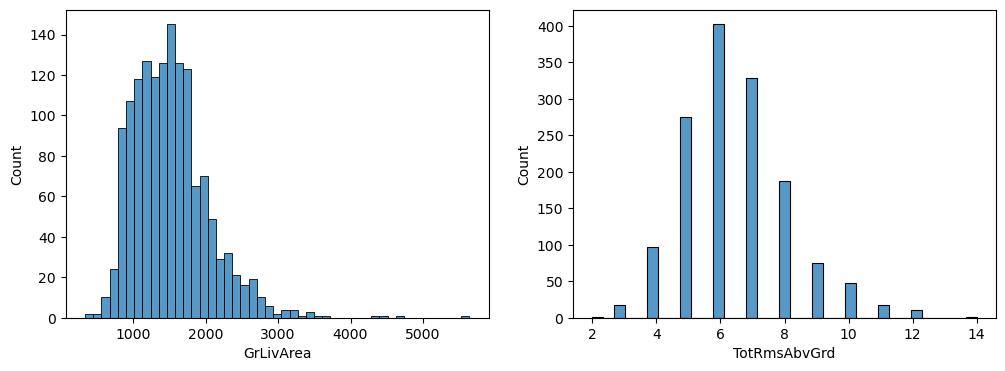

In [109]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data = df3, x = 'GrLivArea', ax = ax1)
sns.histplot(data = df3, x = 'TotRmsAbvGrd', ax = ax2)

- Both distributions look close to normal, but 'GrLivArea' has much higher resolution and is stronger (r=0.71) correlated with the target variable vs 'TotRmsAbvGrd' (r=0.53). That's why we drop the latter.

In [110]:
df3 = df3.drop('TotRmsAbvGrd', axis=1)

- The last pair of strongly correlated features are 'GarageCars' (size of garage in car capacity) and 'GarageArea' (size of garage in square feet).

<Axes: xlabel='GarageArea', ylabel='Count'>

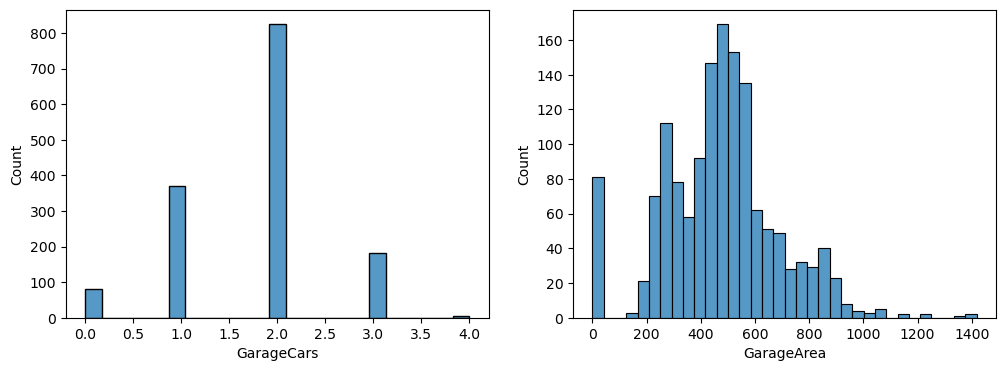

In [111]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data = df3, x = 'GarageCars', ax = ax1)
sns.histplot(data = df3, x = 'GarageArea', ax = ax2)

- Both features are comparable in correlation strength but it seems more reasonable to keep 'GarageArea' feature due to its much higher granularity.

In [112]:
df3 = df3.drop('GarageCars', axis=1)

### Explore distributions of numeric features to decide on whether they should be first transformed before training

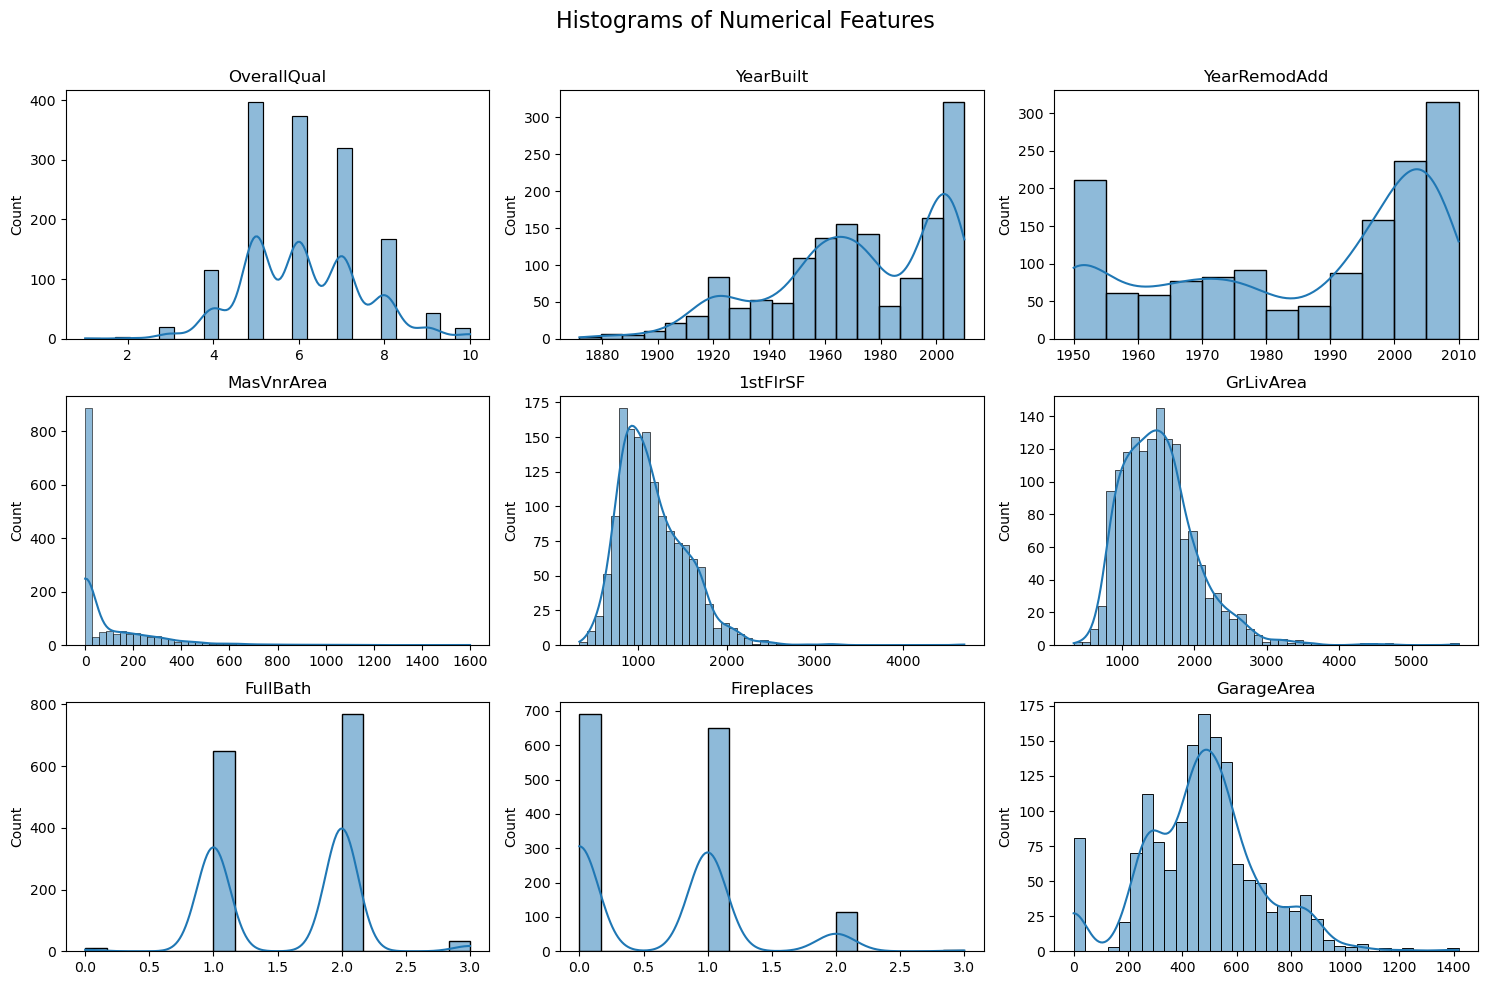

In [113]:
df3_num = df3.select_dtypes(include='number').drop('SalePrice', axis=1) # create numerical dataframe without target

# Get the list of numerical columns
num_cols = df3_num.columns

# Create a 3x3 grid of subplots (there are 9 of those in total)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
fig.suptitle('Histograms of Numerical Features', fontsize=16)

# Flatten the axes array for easier iteration (axes is a 3x3 array)
axes = axes.flatten()

# Plot a histogram for each numerical column
for i, col in enumerate(num_cols):
    sns.histplot(data=df3_num, x=col, ax=axes[i], kde=True)  # kde=True adds a density curve
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust top to make room for the main title

plt.show()

### Brief analysis
1) OverallQual: the distribution is fairly symmetric and discrete (1-10). Linear regression can handle this as-is, and polynomial terms won’t be overly distorted. Transformation no needed.
2) YearBuilt: the distribution isn’t heavily skewed, and years are naturally linear. However, for polynomial regression, large values (e.g., 2000² = 4,000,000) can cause numerical issues. Centering (e.g., YearBuilt - 1900) reduces the range (e.g., 0-120), making polynomial terms more stable.

In [114]:
df3['YearBuilt'] = df3['YearBuilt'] - 1900

3) YearRemodAdd: similar to YearBuilt, the distribution has moderate skew but is usable as-is. Centering helps with polynomial terms.

In [115]:
df3['YearRemodAdd'] = df3['YearRemodAdd'] - 1950

4) MasVnrArea: zero-inflated and heavily right-skewed. Log transformation will reduces skew, and introducing a binary indicator will capture the zero vs. non-zero effect. Since log(0) is undefined we will use log(1+x) to handle zeroes.

In [116]:
df3['HasVnr'] = (df3['MasVnrArea'] > 0).astype(int)
df3['MasVnrArea'] = np.log1p(df3['MasVnrArea'])

5) 1stFlrSF: strong right skew. Log transformation makes the distribution more normal and stabilizes polynomial terms.

In [117]:
df3['1stFlrSF'] = np.log1p(df3['1stFlrSF'])

6) GrLivArea: strong right skew. Log transformation will help.

In [118]:
df3['GrLivArea'] = np.log1p(df3['GrLivArea'])

7. FullBath: discrete with slight skew, but the range (0-3) is small, so linear regression can handle it. For polynomial regression, the small range means squares/cubes won’t explode.

8) Fireplaces: zero-inflated and right-skewed. We'll split into a binary and log-transform non-zero values.

In [119]:
df3['HasFireplace'] = (df3['Fireplaces'] > 0).astype(int)
df3['Fireplaces'] = np.log1p(df3['Fireplaces'])

9) GarageArea: right-skewed with some zeros. Log-transformation (log1p) will handle this.

In [120]:
df3['GarageArea'] = np.log1p(df3['GarageArea'])

### Normalizing numerical features

In [121]:
scaler = StandardScaler()
df3[num_cols] = scaler.fit_transform(df3[num_cols])

### Now let's deal with the categorical features

In [122]:
df3.select_dtypes(exclude='number').nunique()

MSZoning          5
Street            2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
Heating           6
HeatingQC         5
CentralAir        2
KitchenQual       4
Functional        7
PavedDrive        3
SaleType          9
SaleCondition     6
dtype: int64

- Those are too many, so it's very time consuming to analyze all of them one by one. Let's select only those that after one-hot-encoding correlate to the target with at least |r|>0.3 correlation strength. Being per se boolean they don't tend to correlate so easily, so would be good to keep some for the model.

In [123]:
categorical_cols = df3.select_dtypes(exclude='number').columns

# Encode all dummies
df_dummies = pd.get_dummies(df3[categorical_cols])

# Filter by correlation
correlations = df_dummies.corrwith(df3['SalePrice']).abs()
selected_dummies = correlations[correlations > 0.3].index  # Cutoff set down to |r|>0.3 to prevent losing the total majority of boolean features

# For each feature, keep filtered dummies and drop one if >1 remain
final_dummies = pd.DataFrame()
for col in categorical_cols:
    feature_dummies = [d for d in selected_dummies if d.startswith(col + '_')]
    if len(feature_dummies) > 1:  # Multiple dummies passed
        # Sort by correlation and drop the weakest
        dummy_corrs = correlations[feature_dummies].sort_values(ascending=False)
        keep_dummies = dummy_corrs.index[1:]  # Drop lowest
        final_dummies = pd.concat([final_dummies, df_dummies[keep_dummies]], axis=1)
    elif len(feature_dummies) == 1:  # Only one passed
        final_dummies = pd.concat([final_dummies, df_dummies[feature_dummies]], axis=1)

# Combine with numeric features
final_df = pd.concat([df3.select_dtypes(include='number'), final_dummies], axis=1)

In [124]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   OverallQual            1460 non-null   float64
 1   YearBuilt              1460 non-null   float64
 2   YearRemodAdd           1460 non-null   float64
 3   MasVnrArea             1460 non-null   float64
 4   1stFlrSF               1460 non-null   float64
 5   GrLivArea              1460 non-null   float64
 6   FullBath               1460 non-null   float64
 7   Fireplaces             1460 non-null   float64
 8   GarageArea             1460 non-null   float64
 9   SalePrice              1460 non-null   int64  
 10  HasVnr                 1460 non-null   int32  
 11  HasFireplace           1460 non-null   int32  
 12  Neighborhood_NoRidge   1460 non-null   bool   
 13  Exterior1st_VinylSd    1460 non-null   bool   
 14  Exterior2nd_VinylSd    1460 non-null   bool   
 15  Exte

## 5-Fold Cross-Validation for Linear Regression

In [137]:
X = final_df.drop('SalePrice', axis=1)  # Features (numeric + dummies)
y = final_df['SalePrice']  # Target

In [138]:
# Linear Regression
lin_reg = LinearRegression()

# 5-fold cross-validation with RMSE
# cross_val_score uses negative MSE by default, so we negate and square root
scores = cross_val_score(lin_reg, X, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)

# Results
print("Linear Regression 5-Fold RMSE Scores:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("Standard Deviation of RMSE:", rmse_scores.std())

Linear Regression 5-Fold RMSE Scores: [29662.49210075 38277.85210151 37231.24765055 31036.84295018
 41541.42308381]
Mean RMSE: 35549.97157735636
Standard Deviation of RMSE: 4498.805555599391


In [139]:
y_log = np.log1p(df['SalePrice'])
scores = cross_val_score(LinearRegression(), X, y_log, cv=5, scoring='neg_mean_squared_error')
rmse_log = np.sqrt(-scores)
print("Linear Regression (Log Target) 5-Fold RMSE Scores:", rmse_log)
print("Linear Regression (Log Target) Mean RMSE (Log Scale):", rmse_log.mean())
print("Standard Deviation (Log Target) of RMSE:", rmse_log.std())

Linear Regression (Log Target) 5-Fold RMSE Scores: [0.1436673  0.17230694 0.15840658 0.14704641 0.17595074]
Linear Regression (Log Target) Mean RMSE (Log Scale): 0.1594755918006338
Standard Deviation (Log Target) of RMSE: 0.012973845791071723


In [140]:
# Finding out how much it's in dollars
lin_reg.fit(X, np.log1p(y))
y_pred_log = lin_reg.predict(X)
y_pred = np.expm1(y_pred_log)       # inverse of np.log1p

rmse_dollars = np.sqrt(mean_squared_error(y, y_pred))
print("RMSE in Dollars:", rmse_dollars)

RMSE in Dollars: 34129.06519204728


## 5-Fold Cross-Validation for Polynomial Regression

In [141]:
# Polynomial Regression (degree 2)
degree = 2
polyreg = make_pipeline(PolynomialFeatures(degree), StandardScaler(), LinearRegression())

# 5-fold cross-validation with RMSE
poly_scores = cross_val_score(polyreg, X, y, cv=5, scoring='neg_mean_squared_error')
poly_rmse_scores = np.sqrt(-poly_scores)

# Results
print("Polynomial Regression 5-Fold RMSE Scores:", poly_rmse_scores)
print("Mean RMSE:", poly_rmse_scores.mean())
print("Standard Deviation of RMSE:", poly_rmse_scores.std())

Polynomial Regression 5-Fold RMSE Scores: [45631.62181848 47445.23462709 77980.51441525 53825.2907037
 57836.33673099]
Mean RMSE: 56543.799659101365
Standard Deviation of RMSE: 11579.751235897686


In [142]:
from sklearn.linear_model import Ridge

# Ridge Polynomial Regression (degree 2) with regularization
ridge_polyreg = make_pipeline(PolynomialFeatures(degree), StandardScaler(), Ridge(alpha=1.0))

# 5-fold cross-validation with RMSE
ridge_poly_scores = cross_val_score(ridge_polyreg, X, y, cv=5, scoring='neg_mean_squared_error')
ridge_poly_rmse_scores = np.sqrt(-ridge_poly_scores)

# Results
print("Ridge Polynomial Regression 5-Fold RMSE Scores:", ridge_poly_rmse_scores)
print("Mean RMSE:", ridge_poly_rmse_scores.mean())
print("Standard Deviation of RMSE:", ridge_poly_rmse_scores.std())

Ridge Polynomial Regression 5-Fold RMSE Scores: [35404.2089953  45032.91837946 54567.25901019 31826.13272799
 49696.23277874]
Mean RMSE: 43305.35037833502
Standard Deviation of RMSE: 8542.352464107427


In [143]:
# Use GridSearchCV to find the best alpha:

ridge_pipeline = make_pipeline(PolynomialFeatures(degree), StandardScaler(), Ridge())
param_grid = {'ridge__alpha': [0.1, 1.0, 10.0, 100.0]}
grid_search = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)
print("Best alpha:", grid_search.best_params_)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))

Best alpha: {'ridge__alpha': 100.0}
Best RMSE: 36569.88727986525


In [144]:
# Try with log-transformed target
y_log = np.log1p(y)
ridge_poly_scores_log = cross_val_score(ridge_polyreg, X, y_log, cv=5, scoring='neg_mean_squared_error')
print("Ridge Polynomial (Log Target) Mean RMSE (Log Scale):", np.sqrt(-ridge_poly_scores_log).mean())

Ridge Polynomial (Log Target) Mean RMSE (Log Scale): 0.17886240195692818


In [145]:
final_df.SalePrice.describe().round(1)      # descriptive statistics for the target: house selling price

count      1460.0
mean     180921.2
std       79442.5
min       34900.0
25%      129975.0
50%      163000.0
75%      214000.0
max      755000.0
Name: SalePrice, dtype: float64

- Linear Regression: a mean RMSE of 35,550 seems far from ideal but still a good starting point, with moderate consistency (std 4,498). An error of 35K USD with a mean selling price of 180K is not absolutely bad. In any case it’s much better model than that based on polynomial regression.
- Polynomial Regression: a mean RMSE of 56,544 and high variability (std 11,579) look not good. Maybe overfitting? It’s not suitable in its current form.
- The log-transformed target model performs slightly better: with mean RMSE (back converted to dollars) of 34,234. But the difference isn't very indicative.

# A little bit of experimenting for the future 

## GradientBoostingRegressor

In [134]:
# Some features might be noisy or irrelevant, increasing variance
# Use feature importance from GradientBoostingRegressor (or Random Forests) to select the top features

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X, np.log1p(y))
feature_importance = pd.Series(gbr.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importance:\n", feature_importance)

# Drop low-importance features first
low_importance = feature_importance[feature_importance < 0.001].index
X = X.drop(columns=low_importance)
print("Dropped features:", low_importance)

Feature Importance:
 OverallQual       0.502528
GrLivArea         0.180154
YearBuilt         0.078231
1stFlrSF          0.074449
GarageArea        0.073789
YearRemodAdd      0.037083
HasFireplace      0.026817
FullBath          0.008456
Fireplaces        0.005659
KitchenQual_Ex    0.004685
KitchenQual_Gd    0.004391
MasVnrArea        0.002155
SaleType_New      0.001604
dtype: float64
Dropped features: Index([], dtype='object')


In [135]:
feature_importance = feature_importance[feature_importance >= 0.001]  # Update feature importance
top_features = feature_importance.index
X = X[top_features]

In [136]:
X.columns

Index(['OverallQual', 'GrLivArea', 'YearBuilt', '1stFlrSF', 'GarageArea',
       'YearRemodAdd', 'HasFireplace', 'FullBath', 'Fireplaces',
       'KitchenQual_Ex', 'KitchenQual_Gd', 'MasVnrArea', 'SaleType_New'],
      dtype='object')

In [146]:
# GradientBoostingRegressor with raw target
gbr = GradientBoostingRegressor(random_state=42)  # random_state for reproducibility

# 5-fold cross-validation (raw SalePrice)
gbr_scores = cross_val_score(gbr, X, y, cv=5, scoring='neg_mean_squared_error')
gbr_rmse_scores = np.sqrt(-gbr_scores)

print("GradientBoostingRegressor (Raw Target) 5-Fold RMSE Scores:", gbr_rmse_scores)
print("Mean RMSE:", gbr_rmse_scores.mean())
print("Standard Deviation of RMSE:", gbr_rmse_scores.std())

GradientBoostingRegressor (Raw Target) 5-Fold RMSE Scores: [25409.10939004 34618.89293234 29442.46543589 24827.65992445
 30905.72743788]
Mean RMSE: 29040.77102412
Standard Deviation of RMSE: 3624.752024930316


In [147]:
from sklearn.model_selection import cross_val_predict

# GradientBoostingRegressor with log-transformed target
gbr_scores_log = cross_val_score(gbr, X, y_log, cv=5, scoring='neg_mean_squared_error')
gbr_rmse_scores_log = np.sqrt(-gbr_scores_log)

print("GradientBoostingRegressor (Log Target) 5-Fold RMSE (Log Scale):", gbr_rmse_scores_log)
print("Mean RMSE (Log Scale):", gbr_rmse_scores_log.mean())

# Approximate RMSE in dollars (fit on full data for exact value)
gbr_pred_log = cross_val_predict(gbr, X, y_log, cv=5)
gbr_pred = np.expm1(gbr_pred_log)  # Reverse log1p
rmse_dollars = np.sqrt(mean_squared_error(y, gbr_pred))
print("5-Fold RMSE in Dollars (Log Target):", rmse_dollars)

GradientBoostingRegressor (Log Target) 5-Fold RMSE (Log Scale): [0.1460598  0.16781449 0.15970625 0.13706931 0.15147313]
Mean RMSE (Log Scale): 0.15242459691219465
5-Fold RMSE in Dollars (Log Target): 29870.563723984706


In [148]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}
gbr_tuned = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
gbr_tuned.fit(X, y_log)
print("Best Parameters:", gbr_tuned.best_params_)
print("Best RMSE (Log Scale):", np.sqrt(-gbr_tuned.best_score_))

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best RMSE (Log Scale): 0.15279617844068935


## Try Random Forests

In [149]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict

rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_grid = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X, np.log1p(y))
print("Best Parameters:", rf_grid.best_params_)
print("Best RMSE (Log Scale):", np.sqrt(-rf_grid.best_score_))
y_pred_log = cross_val_predict(rf_grid.best_estimator_, X, np.log1p(y), cv=5)
y_pred = np.expm1(y_pred_log)
rmse_dollars = np.sqrt(mean_squared_error(y, y_pred))
print("Tuned RF RMSE in Dollars:", rmse_dollars)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best RMSE (Log Scale): 0.15916423343740718
Tuned RF RMSE in Dollars: 32671.802786475346
